In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pathlib
data_directory = pathlib.Path('dataset-87000/asl_alphabet_train');
len(list(data_directory.glob('*/*.jpg')))

87000

In [3]:
import os
folder_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]


In [4]:
folder_names = sorted(folder_names, key=lambda x: (x[0].islower(), x))
folder_names[:2], folder_names[26:]

(['A', 'B'], ['del', 'nothing', 'space'])

In [5]:
alphabet_images_dict = {
    folder: list(data_directory.glob(f"{folder}/*"))
    for folder in os.listdir(data_directory)
    if(data_directory / folder).is_dir()
}
total_images_dict = sum(len(images) for images in alphabet_images_dict.values())
total_images_dict

87000

In [6]:
alphabet_labels_dict = {
    folder: index for index, folder in enumerate(folder_names)
}
alphabet_labels_dict['A'], alphabet_labels_dict['B']

(0, 1)

In [7]:
img = cv2.imread(str(alphabet_images_dict['A'][0]))
img.shape

(200, 200, 3)

In [8]:
X = np.zeros((total_images_dict, 64, 64, 3), dtype=np.float32)
y = np.zeros(total_images_dict, dtype=int)

idx = 0
for alphabet, images in alphabet_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(64, 64))
        X[idx] = resized_img
        y[idx] = alphabet_labels_dict[alphabet]
        idx += 1

In [9]:
X_scaled = X / 255

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)

In [24]:
num_classes = 29

# Model Definition
model = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes)
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

def add_noise(image):
    noise = np.random.normal(loc=0, scale=0.05, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    preprocessing_function=add_noise,
    shear_range=0.1,
    horizontal_flip=False
)

# Train the Model
model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  
    epochs=39,
    steps_per_epoch=len(X_train) // 32  # Ensures one full pass over the dataset per epoch
)



Epoch 1/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 285s 122ms/step - accuracy: 0.3748 - loss: 2.0928
Epoch 2/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.7812 - loss: 0.6380    
Epoch 3/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 285s 124ms/step - accuracy: 0.8598 - loss: 0.4197
Epoch 4/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.9375 - loss: 0.1380    
Epoch 5/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 286s 124ms/step - accuracy: 0.9153 - loss: 0.2572
Epoch 6/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.9688 - loss: 0.0988    
Epoch 7/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 287s 124ms/step - accuracy: 0.9378 - loss: 0.1909
Epoch 8/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.9375 - loss: 0.3299    
Epoch 9/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 287s 124ms/step - accuracy: 0.9442 - loss: 0.1670
Epoch 10/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.9688 - loss: 0.4150    
Epoch 11/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 287s 124ms/step - accuracy: 0.9517 -

In [25]:
model.evaluate(X_test, y_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9969 - loss: 0.0106


[0.009092948399484158, 0.9973946213722229]

In [26]:
X_test.shape, X_train.shape

((13050, 64, 64, 3), (73950, 64, 64, 3))

In [27]:
predictions = model.predict(X_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


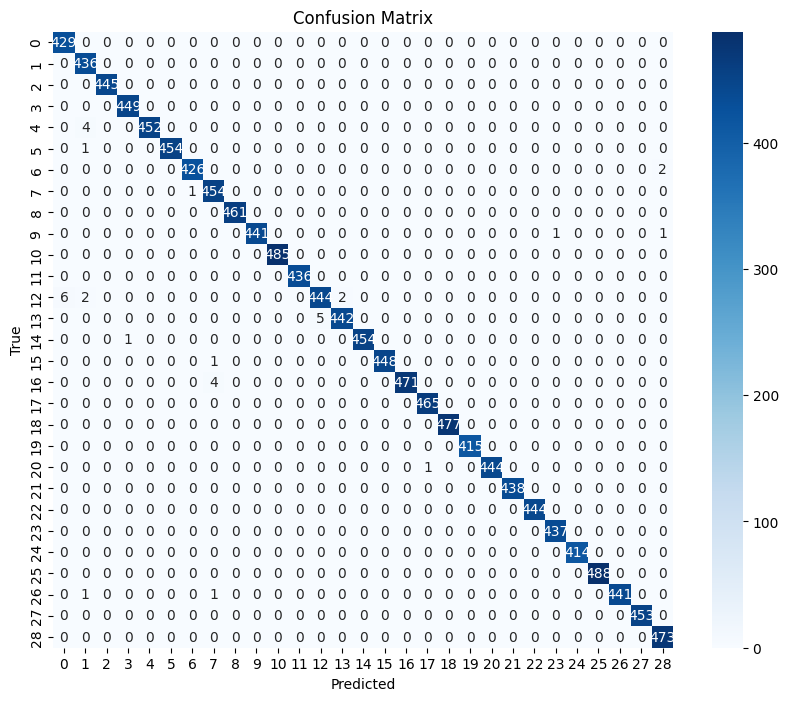

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99       429\n           1       0.98      1.00      0.99       436\n           2       1.00      1.00      1.00       445\n           3       1.00      1.00      1.00       449\n           4       1.00      0.99      1.00       456\n           5       1.00      1.00      1.00       455\n           6       1.00      1.00      1.00       428\n           7       0.99      1.00      0.99       455\n           8       1.00      1.00      1.00       461\n           9       1.00      1.00      1.00       443\n          10       1.00      1.00      1.00       485\n          11       1.00      1.00      1.00       436\n          12       0.99      0.98      0.98       454\n          13       1.00      0.99      0.99       447\n          14       1.00      1.00      1.00       455\n          15       1.00      1.00      1.00       449\n          16       1.00      0.99      1.00       475\n       

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report(y_test, y_pred)


In [29]:
y_pred = np.argmax(model.predict(X_test), axis=1)


408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


In [30]:
y_pred[:15], y_test[:15]

(array([22,  4, 14, 10, 13,  2, 11, 26, 26, 10,  6,  7, 20, 20, 25],
       dtype=int64),
 array([22,  4, 14, 10, 13,  2, 11, 26, 26, 10,  6,  7, 20, 20, 25]))

In [31]:
test_directory = pathlib.Path('dataset-87000/asl_alphabet_test');
len(list(test_directory.glob('*/*.jpg')))

29

In [32]:
jpg_files = [str(file) for file in test_directory.glob('*/*.jpg')]
jpg_files

['dataset-87000\\asl_alphabet_test\\A\\A_test.jpg',
 'dataset-87000\\asl_alphabet_test\\B\\B_test.jpg',
 'dataset-87000\\asl_alphabet_test\\C\\C_test.jpg',
 'dataset-87000\\asl_alphabet_test\\D\\D_test.jpg',
 'dataset-87000\\asl_alphabet_test\\del\\del_test.jpg',
 'dataset-87000\\asl_alphabet_test\\E\\E_test.jpg',
 'dataset-87000\\asl_alphabet_test\\F\\F_test.jpg',
 'dataset-87000\\asl_alphabet_test\\G\\G_test.jpg',
 'dataset-87000\\asl_alphabet_test\\H\\H_test.jpg',
 'dataset-87000\\asl_alphabet_test\\I\\I_test.jpg',
 'dataset-87000\\asl_alphabet_test\\J\\J_test.jpg',
 'dataset-87000\\asl_alphabet_test\\K\\K_test.jpg',
 'dataset-87000\\asl_alphabet_test\\L\\L_test.jpg',
 'dataset-87000\\asl_alphabet_test\\M\\M_test.jpg',
 'dataset-87000\\asl_alphabet_test\\N\\N_test.jpg',
 'dataset-87000\\asl_alphabet_test\\nothing\\nothing_test.jpg',
 'dataset-87000\\asl_alphabet_test\\O\\O_test.jpg',
 'dataset-87000\\asl_alphabet_test\\P\\P_test.jpg',
 'dataset-87000\\asl_alphabet_test\\Q\\Q_test.jp

In [33]:
predictions_dict = {}
for i in jpg_files:
    img = cv2.imread(i)
    resized_img = cv2.resize(img,(64,64))
    scaled_img = resized_img.astype(np.float32) / 255.0
    scaled_img = np.expand_dims(scaled_img, axis=0)
    pred = np.argmax(model.predict(scaled_img))
    predictions_dict[i] = pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [34]:
predictions_dict

{'dataset-87000\\asl_alphabet_test\\A\\A_test.jpg': 0,
 'dataset-87000\\asl_alphabet_test\\B\\B_test.jpg': 1,
 'dataset-87000\\asl_alphabet_test\\C\\C_test.jpg': 2,
 'dataset-87000\\asl_alphabet_test\\D\\D_test.jpg': 3,
 'dataset-87000\\asl_alphabet_test\\del\\del_test.jpg': 26,
 'dataset-87000\\asl_alphabet_test\\E\\E_test.jpg': 4,
 'dataset-87000\\asl_alphabet_test\\F\\F_test.jpg': 5,
 'dataset-87000\\asl_alphabet_test\\G\\G_test.jpg': 6,
 'dataset-87000\\asl_alphabet_test\\H\\H_test.jpg': 7,
 'dataset-87000\\asl_alphabet_test\\I\\I_test.jpg': 8,
 'dataset-87000\\asl_alphabet_test\\J\\J_test.jpg': 9,
 'dataset-87000\\asl_alphabet_test\\K\\K_test.jpg': 10,
 'dataset-87000\\asl_alphabet_test\\L\\L_test.jpg': 11,
 'dataset-87000\\asl_alphabet_test\\M\\M_test.jpg': 12,
 'dataset-87000\\asl_alphabet_test\\N\\N_test.jpg': 13,
 'dataset-87000\\asl_alphabet_test\\nothing\\nothing_test.jpg': 27,
 'dataset-87000\\asl_alphabet_test\\O\\O_test.jpg': 14,
 'dataset-87000\\asl_alphabet_test\\P\\P_t

In [35]:
for key, value in predictions_dict.items():
    for alpha, label in alphabet_labels_dict.items():
        if value == label:
            predictions_dict[key] = alpha

In [36]:
predictions_dict

{'dataset-87000\\asl_alphabet_test\\A\\A_test.jpg': 'A',
 'dataset-87000\\asl_alphabet_test\\B\\B_test.jpg': 'B',
 'dataset-87000\\asl_alphabet_test\\C\\C_test.jpg': 'C',
 'dataset-87000\\asl_alphabet_test\\D\\D_test.jpg': 'D',
 'dataset-87000\\asl_alphabet_test\\del\\del_test.jpg': 'del',
 'dataset-87000\\asl_alphabet_test\\E\\E_test.jpg': 'E',
 'dataset-87000\\asl_alphabet_test\\F\\F_test.jpg': 'F',
 'dataset-87000\\asl_alphabet_test\\G\\G_test.jpg': 'G',
 'dataset-87000\\asl_alphabet_test\\H\\H_test.jpg': 'H',
 'dataset-87000\\asl_alphabet_test\\I\\I_test.jpg': 'I',
 'dataset-87000\\asl_alphabet_test\\J\\J_test.jpg': 'J',
 'dataset-87000\\asl_alphabet_test\\K\\K_test.jpg': 'K',
 'dataset-87000\\asl_alphabet_test\\L\\L_test.jpg': 'L',
 'dataset-87000\\asl_alphabet_test\\M\\M_test.jpg': 'M',
 'dataset-87000\\asl_alphabet_test\\N\\N_test.jpg': 'N',
 'dataset-87000\\asl_alphabet_test\\nothing\\nothing_test.jpg': 'nothing',
 'dataset-87000\\asl_alphabet_test\\O\\O_test.jpg': 'O',
 'datas

In [37]:
model.save('SignLanguageRecognition-87000.keras')